In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [41]:
from pathlib import Path

import datasets
import h5py
import matplotlib.pyplot as plt
import transformers
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
%load_ext autoreload
%autoreload 2

In [18]:
from models.frame_level import FrameLevelRNNClassifier
from models.transformer import TilingWordFeatureExtractor2, DataCollator, drop_wav2vec_layers
from utils.timit import group_phonetic_detail

## Inner model and corpus prep

In [5]:
device = "cuda:0"

In [6]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
model = transformers.Wav2Vec2ForCTC.from_pretrained("charsiu/en_w2v2_ctc_libris_and_cv")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enabl

In [7]:
corpus = datasets.load_dataset("timit_asr", data_dir="/userdata/jgauthier/data/TIMIT")

In [8]:
# TODO cross-check resulting mappings with cmudict
TIMIT_MAPPING = {
    'ax': 'AH',
    'ax-h': 'AH',
    'axr': 'ER',
    'dx': 'T',
    'el': ['AH', 'L'],
    'em': ['AH', 'M'],
    'en': ['AH', 'N'],
    'eng': ['IH', 'NG'],
    'hv': 'HH',
    'ix': 'IH',
    'nx': ['N', 'T'],
    'q': 'T',
    'pau': '[SIL]',
    'epi': '[SIL]',
    'ux': 'UW'
}

VOCAB = set(tokenizer.get_vocab().keys())
for src, tgt in TIMIT_MAPPING.items():
    if isinstance(tgt, str):
        tgt = [tgt]
    for t in tgt:
        assert t in VOCAB

In [9]:
TIMIT_IGNORE = ["h#"]
TIMIT_JOIN_CLOSURES = ['bcl', 'dcl', 'gcl', 'kcl', 'pcl', 'tcl']


def map_timit_phone_to_cmudict_phoneme(phone):
    if phone in TIMIT_IGNORE:
        return []
    elif phone in TIMIT_MAPPING:
        ret = TIMIT_MAPPING[phone]
        if isinstance(ret, str):
            ret = [ret]
        return ret
    elif not phone.upper() in VOCAB:
        raise ValueError(f"Invalid phone {phone.upper()}")
    return [phone.upper()]


def map_timit_to_cmudict(timit_item):
    phonemes = []

    i = 0
    phonetic_detail = timit_item["phonetic_detail"]
    num_phones = len(phonetic_detail["start"])
    while i < num_phones:
        phone = phonetic_detail["utterance"][i]
        start = phonetic_detail["start"][i]
        stop = phonetic_detail["stop"][i]

        if phone in TIMIT_IGNORE:
            i += 1
        elif phone in TIMIT_JOIN_CLOSURES:
            release_phone = phone[:-len("cl")]
            if phonetic_detail["utterance"][i + 1] == release_phone:
                phoneme_start = start
                phoneme_end = phonetic_detail["stop"][i + 1]
                phoneme_label = map_timit_phone_to_cmudict_phoneme(release_phone)

                for phoneme in phoneme_label:
                    phonemes.append((phoneme_start, phoneme_end, phoneme))
                i += 2
            else:
                phoneme_label = map_timit_phone_to_cmudict_phoneme(release_phone)
                for phoneme in phoneme_label:
                    phonemes.append((start, stop, phoneme))
                i += 1
        else:
            for phoneme in map_timit_phone_to_cmudict_phoneme(phone):
                phonemes.append((start, stop, phoneme))
            i += 1

    return phonemes


def add_phonemic_detail(item):
    phonemes = map_timit_to_cmudict(item)
    # TODO group by word

    starts, stops, utterances = zip(*phonemes)
    item["phonemic_detail"] = {
        "start": starts,
        "stop": stops,
        "utterance": utterances
    }

    return item

    
corpus = corpus.map(add_phonemic_detail, batched=False, load_from_cache_file=False)

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [10]:
def prepare_corpus(processor, drop_phones=None):
    corpus = datasets.load_dataset("timit_asr", data_dir="/userdata/jgauthier/data/TIMIT")

    corpus = corpus.map(add_phonemic_detail, batched=False)

    # Compute phonetic and phonemic details grouped by word span
    corpus = corpus.map(group_phonetic_detail, batched=False,
                        fn_kwargs=dict(drop_phones=drop_phones))
    corpus = corpus.map(group_phonetic_detail, batched=False,
                        fn_kwargs=dict(key="phonemic_detail"))
    
    def prepare_audio(batch):
        audio = batch["audio"]
        batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
        return batch
    corpus = corpus.map(prepare_audio)

    twfe = TilingWordFeatureExtractor2(tokenizer, item_key="word_phonemic_detail")
    def add_features(example):
        example["phone_targets"] = twfe(example)
        return example
    corpus = corpus.map(add_features, load_from_cache_file=False)
    
    return corpus

In [11]:
def load_corpus(processor, corpus_path="timit_phoneme_corpus"):
    if not Path(corpus_path).exists():
        corpus = prepare_corpus(processor)
        corpus.save_to_disk(corpus_path)
    else:
        corpus = datasets.load_from_disk(corpus_path)

    return corpus

In [12]:
corpus = load_corpus(processor)

In [13]:
corpora_split = corpus["train"].train_test_split(test_size=0.1, shuffle=True)
train_corpus, eval_corpus = corpora_split["train"], corpora_split["test"]

## Model prep

In [14]:
def make_model_init(model_name_or_path, config, device="cpu"):
    def model_init(trial):
        model = FrameLevelRNNClassifier.from_pretrained(
            model_name_or_path, config=config).to(device)

        model.freeze_feature_extractor()

        if hasattr(config, "drop_layers"):
            model.wav2vec2 = drop_wav2vec_layers(model.wav2vec2, config.drop_layers)

        # Freeze all model weights.
        for param in model.wav2vec2.parameters():
            param.requires_grad = False
        
        return model
    return model_init

In [15]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    label_mask, labels = p.label_ids

    def evaluate_label(j):
        preds_j = preds[:, :, j]
        labels_j = labels[:, :, j]

        preds_j = preds_j[label_mask == 1]
        labels_j = labels_j[label_mask == 1]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

In [25]:
model_name_or_path = "charsiu/en_w2v2_ctc_libris_and_cv"
config = transformers.AutoConfig.from_pretrained(
        model_name_or_path,
        num_labels=tokenizer.vocab_size)
setattr(config, "classifier_bias", True)
setattr(config, "rnn_hidden_size", 128)
setattr(config, "rnn_num_layers", 2)
setattr(config, "drop_layers", 6)
model_init = make_model_init(model_name_or_path, config, device=device)

/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [26]:
coll = DataCollator(processor=processor, model=model_init(None), padding=True,
                    num_labels=tokenizer.vocab_size)

Some weights of FrameLevelRNNClassifier were not initialized from the model checkpoint at charsiu/en_w2v2_ctc_libris_and_cv and are newly initialized: ['rnn.bias_ih_l1', 'classifier.weight', 'rnn.bias_hh_l0', 'classifier.bias', 'rnn.weight_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.weight_hh_l1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
training_args = TrainingArguments(
    output_dir=f"out/rnn/rnn{config.rnn_num_layers}_hidden{config.rnn_hidden_size}_drop{config.drop_layers}",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=50,
    gradient_accumulation_steps=2,
    save_steps=50,
    eval_steps=50,
    logging_steps=2,
    learning_rate=1e-2,
    save_total_limit=5,
    use_cpu=False,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    label_names=["label_mask", "labels"],
    disable_tqdm=True,
)

trainer = Trainer(
    model=None, model_init=model_init,
    data_collator=coll,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics,
    train_dataset=train_corpus,
    eval_dataset=eval_corpus,
    tokenizer=processor.feature_extractor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of FrameLevelRNNClassifier were not initialized from the model checkpoint at charsiu/en_w2v2_ctc_libris_and_cv and are newly initialized: ['rnn.bias_ih_l1', 'classifier.weight', 'rnn.bias_hh_l0', 'classifier.bias', 'rnn.weight_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.weight_hh_l1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
trainer.train()

Some weights of FrameLevelRNNClassifier were not initialized from the model checkpoint at charsiu/en_w2v2_ctc_libris_and_cv and are newly initialized: ['rnn.bias_ih_l1', 'classifier.weight', 'rnn.bias_hh_l0', 'classifier.bias', 'rnn.weight_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.weight_hh_l1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6697, 'learning_rate': 0.009996923076923077, 'epoch': 0.02}
{'loss': 0.3622, 'learning_rate': 0.009993846153846155, 'epoch': 0.03}
{'loss': 0.2862, 'learning_rate': 0.009990769230769232, 'epoch': 0.05}
{'loss': 0.3042, 'learning_rate': 0.009987692307692307, 'epoch': 0.06}
{'loss': 0.297, 'learning_rate': 0.009984615384615385, 'epoch': 0.08}
{'loss': 0.2864, 'learning_rate': 0.009981538461538462, 'epoch': 0.09}
{'loss': 0.2755, 'learning_rate': 0.009978461538461538, 'epoch': 0.11}
{'loss': 0.2858, 'learning_rate': 0.009975384615384615, 'epoch': 0.12}
{'loss': 0.2848, 'learning_rate': 0.009972307692307694, 'epoch': 0.14}
{'loss': 0.2698, 'learning_rate': 0.00996923076923077, 'epoch': 0.15}
{'loss': 0.2767, 'learning_rate': 0.009966153846153845, 'epoch': 0.17}
{'loss': 0.2667, 'learning_rate': 0.009963076923076923, 'epoch': 0.18}
{'loss': 0.2752, 'learning_rate': 0.00996, 'epoch': 0.2}
{'loss': 0.265, 'learning_rate': 0.009956923076923077, 'epoch': 0.22}
{'loss': 0.2801, 'learn

TrainOutput(global_step=3850, training_loss=0.1408536762231356, metrics={'train_runtime': 4580.3741, 'train_samples_per_second': 45.389, 'train_steps_per_second': 1.419, 'train_loss': 0.1408536762231356, 'epoch': 29.62})

## Serialize outputs

### Estimate optimal decision thresholds

In [37]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(eval_corpus)
    label_mask, labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

In [38]:
# Get optimal cut-off for each phone
optimal_thresholds = []
fpr, tpr, thresholds = [], [], []
roc_aucs = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, :, j]
    labels_j = labels[:, :, j]

    mask = label_mask == 1
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    fpr.append(fpr_j)
    tpr.append(tpr_j)
    thresholds.append(thresholds_j)
    
    if labels_j.std() == 0:
        roc_aucs.append(None)
    else:
        roc_aucs.append(roc_auc_score(labels_j, preds_j))

    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


tensor([-4.3942, -3.1447, -2.7884, -2.0110, -2.5602, -1.5113, -2.4273, -1.8118,
        -1.3793, -3.3139, -2.6026, -4.7700, -2.8357, -1.9733, -1.8696, -2.3847,
        -2.1874, -1.2392, -3.0384, -2.5830, -2.6496, -5.4960, -0.7835, -2.0357,
        -2.6419, -1.5432, -2.4798, -2.0564, -3.9608, -3.1859, -2.2334, -2.5149,
        -1.7290, -2.3908, -3.4296, -2.5658, -1.5435, -2.1618, -0.7998, -1.0337,
            inf,     inf])

In [39]:
roc_aucs = pd.Series(roc_aucs, index=tokenizer.convert_ids_to_tokens(range(tokenizer.vocab_size))).sort_values(ascending=False)
roc_aucs

OY       0.987279
P        0.984671
W        0.984344
F        0.982790
SH       0.981685
K        0.981548
M        0.981149
Y        0.979696
DH       0.979587
G        0.979544
CH       0.978620
L        0.977711
HH       0.977550
UW       0.975991
AE       0.975209
AW       0.974566
N        0.973155
B        0.972989
S        0.972008
R        0.971433
JH       0.970980
AY       0.970906
AO       0.970784
OW       0.968783
AA       0.968119
Z        0.967927
EY       0.966116
IY       0.965785
NG       0.963536
ER       0.962006
V        0.960235
TH       0.956077
D        0.947857
T        0.935568
EH       0.934208
IH       0.916518
AH       0.907906
ZH       0.889238
[SIL]    0.881464
UH       0.874950
[UNK]         NaN
[PAD]         NaN
dtype: float64

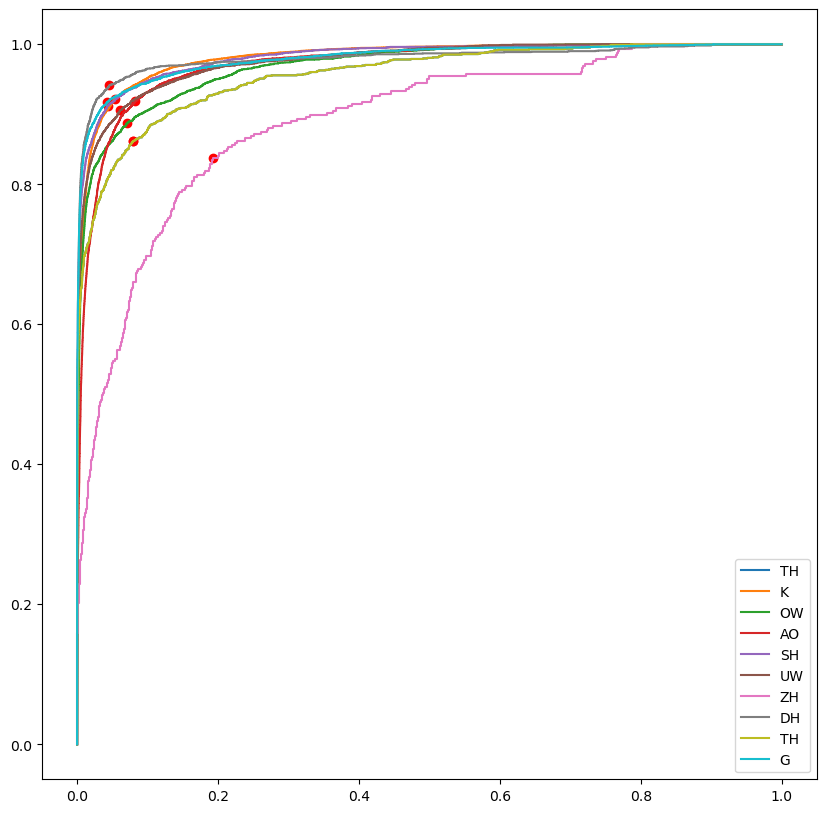

In [42]:
f, ax = plt.subplots(figsize=(10, 10))
for idx in np.random.choice(len(fpr), 10):
    ax.plot(fpr[idx], tpr[idx], label=tokenizer.convert_ids_to_tokens([idx])[0])
    opt_threshold_idx = np.argmax(tpr[idx] - fpr[idx])
    ax.scatter(fpr[idx][opt_threshold_idx], tpr[idx][opt_threshold_idx], c="r")
ax.legend()

In [56]:
test_predictions = trainer.predict(corpus["test"])

In [63]:
def add_predictions(batch, idxs):
    eval_output, rnn_states = test_predictions.predictions
    logits = eval_output[idxs]
    preds = (logits > optimal_thresholds.numpy()).astype(int)

    batch["rnn_hidden_states"] = rnn_states[idxs]
    batch["logits"] = logits
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds.numpy()
    batch["predicted"] = preds

    return batch

test_result = corpus["test"].map(add_predictions, batched=True, batch_size=8, with_indices=True)

def compute_accuracy(item, idx):
    label_mask, labels = test_predictions.label_ids
    label_mask = label_mask[idx] == 1
    labels = labels[idx]

    item["real_frames"] = label_mask.sum()
    item["labels"] = labels[label_mask]
    item["compression_ratio"] = item["real_frames"] / item["input_values"].shape[0]
    item["correct"] = (np.array(item["predicted"])[label_mask] == labels[label_mask])
    item["fp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 0)
    item["fn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 1)
    item["tp"] = (np.array(item["predicted"])[label_mask] == 1) & (labels[label_mask] == 1)
    item["tn"] = (np.array(item["predicted"])[label_mask] == 0) & (labels[label_mask] == 0)
    item["accuracy"] = item["correct"].mean()
    return item

test_result = test_result.map(compute_accuracy, batched=False, with_indices=True)

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [67]:
# Remove columns which are redundant and take up lots of space
test_result = test_result.remove_columns(["audio", "input_values", "phone_targets"])

In [69]:
test_result.save_to_disk(Path(trainer.args.output_dir) / "test_result")

Saving the dataset (0/2 shards):   0%|          | 0/1680 [00:00<?, ? examples/s]